# Initial DDA-atmos testing

This will be a notebook to test the functionality of the DDA-atmos alogrithm on the MPL data I've ingested.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr

In [2]:
import eeasm_icesat.dda as dda
#import eeasm_icesat.mpl as mpl

## Load in the data

I want to load in MPL data that has some cloudy scenes in it that I can possibly compare to the ATL09 data...

In [3]:
fname = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/leeds_ingested/smtmplpolX1.a1.20190311.000000.cdf'

mpl_data = xr.load_dataset(fname)
mpl_data

<xarray.Dataset>
Dimensions:          (time: 17282, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-03-11T00:00:01 ... 2019-03-11...
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/31)
    base_time        datetime64[ns] 2019-03-11T00:00:01
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:58
    hour             (time) float32 0.0002778 0.001667 0.003056 ... 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.235 5.235 5.236 ... 5.184 5.183 5.183
    ...               ...
    E_photon         float64 3.734e-19
    afterpulse_2     (height) float64 0.0002182 0.0003633 ... 0.0003758
    NRB_2            (time, height) float64 nan nan nan nan ... nan nan nan nan
    depol_mpl        (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    depol_linear     (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NRB_total        (time, height) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Date_created:              2023-02-17T23:21:48 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

In [4]:
'''
mpl_data.NRB_total.plot(x='time',y='height',norm=colors.LogNorm(vmin=1e-7,vmax=1))
'''

"\nmpl_data.NRB_total.plot(x='time',y='height',norm=colors.LogNorm(vmin=1e-7,vmax=1))\n"

In [5]:
'''
mpl_data.where(mpl_data.hour > 19,drop=True).sel(height=slice(0,7000)).NRB_total.plot(x='time',y='height')
'''

"\nmpl_data.where(mpl_data.hour > 19,drop=True).sel(height=slice(0,7000)).NRB_total.plot(x='time',y='height')\n"

In [6]:
data_reduced = mpl_data.where(mpl_data.height>=0, drop=True)
data_reduced = data_reduced.where(data_reduced.hour<15,drop=True).where(data_reduced.hour>6,drop=True)
data_reduced

<xarray.Dataset>
Dimensions:          (height: 999, time: 6481)
Coordinates:
  * time             (time) datetime64[ns] 2019-03-11T06:00:01 ... 2019-03-11...
  * height           (height) float64 12.91 27.9 42.89 ... 1.496e+04 1.497e+04
Data variables: (12/31)
    base_time        (height, time) datetime64[ns] 2019-03-11T00:00:01 ... 20...
    time_offset      (time, height) timedelta64[ns] 06:00:00 ... 14:59:55
    hour             (time, height) float32 6.0 6.0 6.0 6.0 ... 15.0 15.0 15.0
    nshots           (time, height) float64 1.25e+04 1.25e+04 ... 1.25e+04
    rep_rate         (time, height) float64 2.5e+03 2.5e+03 ... 2.5e+03 2.5e+03
    energy           (time, height) float32 5.291 5.291 5.291 ... 5.184 5.184
    ...               ...
    E_photon         (height, time) float64 3.734e-19 3.734e-19 ... 3.734e-19
    afterpulse_2     (height, time) float64 0.0003393 0.0003393 ... 0.0003758
    NRB_2            (time, height) float64 nan nan 9.96e-07 nan ... nan nan nan
    depol_mpl        (time, height) float64 0.0 0.0 1.022 0.0 ... 0.0 0.0 0.0
    depol_linear     (time, height) float64 0.0 0.0 0.5055 0.0 ... 0.0 0.0 0.0
    NRB_total        (time, height) float64 nan nan 3.032e-06 ... nan nan nan
Attributes:
    Date_created:              2023-02-17T23:21:48 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

In [7]:
#data_reduced.time[1] - data_reduced.time[0]
5000000000e-9

5.0

## Apply DDA to reduced dataset

To do this, I'll designate the kernal, density and threshold arguments, then set the DDA algorithm loose...

In [8]:
kernal_args = {
    'sigma_y': 90, # pixel-wise if dy is unspecified
    'dy': 15, # in m. Thus, we expect 6 bins to account for 90m
    'sigma_x': 30, # estimated typical change time in seconds
    'dx': 5, # in seconds
    'cutoff': 1.5
}

In [9]:
kernal_args2 = {
    'sigma_y': 120, # pixel-wise if dy is unspecified
    'dy': 15, # in m. Thus, we expect 6 bins to account for 90m
    'sigma_x': 60, # estimated typical change time in seconds
    'dx': 5, # in seconds
    'cutoff': 1.5
}

In [10]:
density_args = {} # simply use default arguments for scipy.signal.conv2d function

In [11]:
threshold_args = {
    'bias': 2e-5,
    'sensitivity': 0.8,
    'quantile': 90
}

In [12]:
threshold_args2 = {
    'bias': 1e-5,
    'sensitivity': 0.8,
    'quantile': 90
}

In [13]:
in_data = data_reduced.NRB_total.values
print(f'{in_data.shape=}')

in_data.shape=(6481, 999)


In [14]:
# shouldn't need to pass in arguments I don't want to change from the default...
dda_out = dda.dda.dda(in_data.T,kernal_args=kernal_args, threshold_args=threshold_args, kernal_args2=kernal_args2, two_pass=True, threshold_args2=threshold_args2)

downsample=0
dda.calc_thresholds: calculating thresholds


/home/users/eeasm/.conda/envs/icesat_summit/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


downsample=0
dda.calc_thresholds: calculating thresholds


In [15]:
for k in dda_out:
    if dda_out[k].ndim == 2:
        data_reduced[k] = (['height','time'],dda_out[k])
    else:
        data_reduced[k] = (['time'],dda_out[k])

data_reduced

<xarray.Dataset>
Dimensions:            (height: 999, time: 6481)
Coordinates:
  * time               (time) datetime64[ns] 2019-03-11T06:00:01 ... 2019-03-...
  * height             (height) float64 12.91 27.9 42.89 ... 1.496e+04 1.497e+04
Data variables: (12/37)
    base_time          (height, time) datetime64[ns] 2019-03-11T00:00:01 ... ...
    time_offset        (time, height) timedelta64[ns] 06:00:00 ... 14:59:55
    hour               (time, height) float32 6.0 6.0 6.0 6.0 ... 15.0 15.0 15.0
    nshots             (time, height) float64 1.25e+04 1.25e+04 ... 1.25e+04
    rep_rate           (time, height) float64 2.5e+03 2.5e+03 ... 2.5e+03
    energy             (time, height) float32 5.291 5.291 5.291 ... 5.184 5.184
    ...                 ...
    density_pass1      (height, time) float64 4.366e-05 4.363e-05 ... 0.0 0.0
    thresholds1        (time) float64 2.656e-05 2.65e-05 2.651e-05 ... nan nan
    density_pass2      (height, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thresholds2        (time) float64 1.716e-05 1.718e-05 1.739e-05 ... nan nan
    cloud_mask_passes  (height, time) int64 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    cloud_mask         (height, time) bool True True True ... False False False
Attributes:
    Date_created:              2023-02-17T23:21:48 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

In [16]:

'''
mH = 10000

fig, axs = plt.subplots(6,1,figsize=(16,24))

data_reduced.NRB_total.where(data_reduced.height<=mH,drop=True).plot(ax=axs[0], x='time', y='height', norm=colors.LogNorm(vmin=1e-5,vmax=1e-3,clip=True))
data_reduced.density_pass1.where(data_reduced.height<=mH,drop=True).plot(ax=axs[1], x='time', y='height', norm=colors.LogNorm(vmin=1e-5,vmax=1e-3,clip=True))
data_reduced.density_pass2.where(data_reduced.height<=mH,drop=True).plot(ax=axs[2], x='time', y='height', norm=colors.LogNorm(vmin=1e-5,vmax=1e-3,clip=True))
data_reduced.cloud_mask.where(data_reduced.height<=mH,drop=True).plot(ax=axs[3], x='time', y='height')
data_reduced.cloud_mask_passes.where(data_reduced.height<=mH,drop=True).plot(ax=axs[4], x='time', y='height')

data_reduced.thresholds1.plot(ax=axs[5])
data_reduced.thresholds2.plot(ax=axs[5])

fig.tight_layout()
plt.show()
'''


"\nmH = 10000\n\nfig, axs = plt.subplots(6,1,figsize=(16,24))\n\ndata_reduced.NRB_total.where(data_reduced.height<=mH,drop=True).plot(ax=axs[0], x='time', y='height', norm=colors.LogNorm(vmin=1e-5,vmax=1e-3,clip=True))\ndata_reduced.density_pass1.where(data_reduced.height<=mH,drop=True).plot(ax=axs[1], x='time', y='height', norm=colors.LogNorm(vmin=1e-5,vmax=1e-3,clip=True))\ndata_reduced.density_pass2.where(data_reduced.height<=mH,drop=True).plot(ax=axs[2], x='time', y='height', norm=colors.LogNorm(vmin=1e-5,vmax=1e-3,clip=True))\ndata_reduced.cloud_mask.where(data_reduced.height<=mH,drop=True).plot(ax=axs[3], x='time', y='height')\ndata_reduced.cloud_mask_passes.where(data_reduced.height<=mH,drop=True).plot(ax=axs[4], x='time', y='height')\n\ndata_reduced.thresholds1.plot(ax=axs[5])\ndata_reduced.thresholds2.plot(ax=axs[5])\n\nfig.tight_layout()\nplt.show()\n"

In [17]:
ds = dda.compute_cloud_layers(data_reduced)
ds

dda.compute_cloud_layers: cloud_mask.shape=(6481, 999)


<xarray.Dataset>
Dimensions:            (layer: 10, time: 6481, height: 999)
Coordinates:
  * layer              (layer) int64 0 1 2 3 4 5 6 7 8 9
  * time               (time) datetime64[ns] 2019-03-11T06:00:01 ... 2019-03-...
  * height             (height) float64 12.91 27.9 42.89 ... 1.496e+04 1.497e+04
Data variables: (12/40)
    base_time          (height, time) datetime64[ns] 2019-03-11T00:00:01 ... ...
    time_offset        (time, height) timedelta64[ns] 06:00:00 ... 14:59:55
    hour               (time, height) float32 6.0 6.0 6.0 6.0 ... 15.0 15.0 15.0
    nshots             (time, height) float64 1.25e+04 1.25e+04 ... 1.25e+04
    rep_rate           (time, height) float64 2.5e+03 2.5e+03 ... 2.5e+03
    energy             (time, height) float32 5.291 5.291 5.291 ... 5.184 5.184
    ...                 ...
    thresholds2        (time) float64 1.716e-05 1.718e-05 1.739e-05 ... nan nan
    cloud_mask_passes  (height, time) int64 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    cloud_mask         (height, time) bool True True True ... False False False
    layer_bot          (layer, time) float64 57.88 57.88 57.88 ... nan nan nan
    layer_top          (layer, time) float64 192.8 192.8 192.8 ... nan nan nan
    cloud_flag_atm     (time) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Date_created:              2023-02-17T23:21:48 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

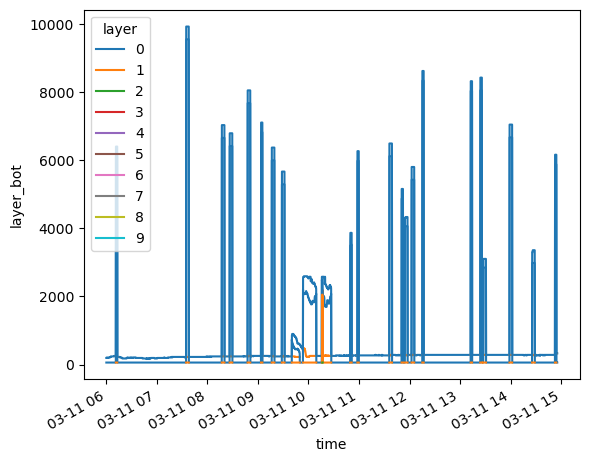

In [18]:
ds.layer_top.plot(x='time',hue='layer')
ds.layer_bot.plot(x='time',hue='layer')